## Task II

## Libraries

We decided to use the the Pytorch framework because of its ease of use and beginner friendly development. Pytorch is also has comprehensive documentation making it easy to research what the framework offers. 

In [145]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from PIL import Image
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Subset, DataLoader
from torch.utils.data import Dataset
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer

In [146]:
# Pytorch transform
transform = v2.Compose([
    # Convert to tensor 
    v2.ToTensor(),
    # Rescale image
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the CIFAR-10 traning set
training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# Loading the CIFAR-10 traning set
test_data = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
# All 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# (PyTorch, 2024)

Transform
We begin by defining a transform to properly preprocess the data. The goal of the transform is to augment or prepare the image in a way that makes it more suitable for the model.

ToTensor() is the first transformation we use. This converts a Python Image Library (PIL) image into a torch.FloatTensor. This is important because PyTorch models expect tensor inputs. During ToTensor, the shape of the PIL image (Height x Width x Channels) is converted to the PyTorch format (Channels x Height x Width). ToTensor() also scales the pixel values from the range [0, 255] to a normalized floating-point range of [0.0, 1.0], which makes the data numerically more suitable for the CNN.

Next, we use the Normalize() transformation. Normalize() standardizes the pixel values for each channel. The Normalize(mean, std) transform is crucial for training deep learning models effectively. mean is a tuple of means for each channel (R, G, B), and std is a tuple of standard deviations for each channel (R, G, B). This transforms each channel using the formula: Output = (input – mean) / std. We use this after ToTensor so every image has a value between 0 and 1. As we used 0.5, for each pixel channel the new value will be: New Value = (Old Value – 0.5) / 0.5.

By combining ToTensor() and Normalize() within a compose pipeline using the Compose class, we ensure our image data is in a good format and scale for input into a PyTorch model.

## Loading the Data 

torchvision.datasets.CIFAR10 is a built-in class we use to load the data. This allows us to download the CIFAR-10 dataset directly into our project directory. We choose this because it makes it easy to manage both the training and test sets by simply setting the train parameter to True or False. When train=True, the class returns the training portion of the dataset, and when False, it loads the test set instead.

The dataset consists of five training batches, each containing 10,000 images. The test set includes exactly 1,000 randomly selected images from each class. The remaining images are shuffled randomly, but the distribution of classes may vary across batches. Altogether, the training sets provide exactly 5,000 images for each class.

In [147]:
# Shape of image
img, label = training_data[0]
img.size()

torch.Size([3, 32, 32])

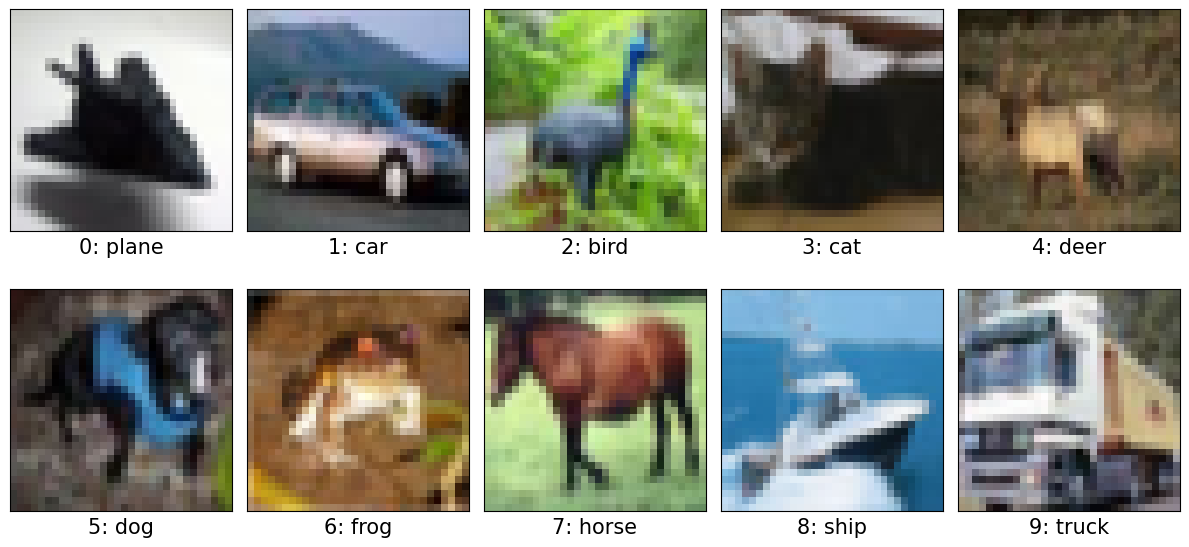

In [148]:
# Visualize one training image per class
sample_images = [training_data.data[np.asarray(training_data.targets) == label][0] for label in range(10)]

# Create a figure with 2 rows and 5 columns
fig, axes = plt.subplots(2, 5, figsize=(12, 6))


for i, axis in enumerate(axes.flat):
    # Set labels: class number: Class
    axis.set_xlabel(f"{i}: {classes[i]}", fontsize=15)
    # Shows the corresponding image of the claass it represents
    axis.imshow(sample_images[i])
    axis.set_xticks([])
    axis.set_yticks([])

# Plot out the images
plt.tight_layout()
plt.show()

# (Nekouei, 2023)

In [149]:
# Function for printing information about a given dataset
def print_stats(dataset, class_names):
    label_counts = {}

    # Checks if the dataset is a Subset object
    if isinstance(dataset, Subset):
        targets = dataset.dataset
        indices = dataset.indices
    else:
        targets = dataset
        indices = range(len(dataset))

    for i in indices:
        _, label = targets[i]
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1

    # Prints out the label and how many images of the given label in the dataset
    print(f"Total images: {len(indices)}")
    for label in sorted(label_counts):
        print(f"Label {label} ({class_names[label]}): {label_counts[label]}")


In [150]:
# Print out traning and test data using print_stats
print("Traning data")
print_stats(training_data, classes)
print("\n")
print("Test data")
print_stats(test_data, classes)

Traning data
Total images: 50000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 5000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


Test data
Total images: 10000
Label 0 (plane): 1000
Label 1 (car): 1000
Label 2 (bird): 1000
Label 3 (cat): 1000
Label 4 (deer): 1000
Label 5 (dog): 1000
Label 6 (frog): 1000
Label 7 (horse): 1000
Label 8 (ship): 1000
Label 9 (truck): 1000


This FrogBinaryDataset class wraps around an existing dataset subset and transforms it into a binary classification task. Inheriting from torch.utils.data.Dataset, it allows easy integration with PyTorch's DataLoader. The key functionality lies in the __getitem__ method, where each label is checked: if it equals 6 (frog), it's converted to 1; otherwise, it becomes 0. This simplifies a multi-class problem—the 10 classes in the dataset—into a binary classification problem: frog and non-frog.

In [151]:
# Class for truning a datase
class FrogBinaryDataset(Dataset):
    def __init__(self, dataset):
        # Data form dataset
        self.dataset = dataset

    # Function for getting a sample form the dataset
    def __getitem__(self, item):
        data, label = self.dataset[item]
        # Convert to binary: 1 if frog (label 6), else 0
        if label == 6:
            binary_label = 1
        else:
            binary_label = 0
        return data, binary_label
    
    # Fucntion for getting the length of the dataset
    def __len__(self):
        return len(self.dataset)
    
# (Pytorch, 2024)

## Building the Training Dataset
A training dataset is the portion of the data used to teach the model. In the case of a neural network, this is the data the model learns from by adjusting its weights and biases during training. Typically, the training set is the largest portion of the dataset. In our case, it makes up approximately 80% of the total data used.

In our approach, we utilized a combination of the original dataset along with an additional 5,000 augmented frog images. This augmentation strategy significantly enhanced the diversity of our training data, allowing the model to generalize better and improve overall performance. By adding augmented images, the model learns better what the frog class looks like, and it also gains the ability to generalize to different types of frog images. In addition, augmentation helps address common problems in CNN models such as overfitting, poor generalization, and low accuracy (Hallaj, 2023).

However, some disadvantages of using augmented images include increased computational cost and the potential for introducing noise. Regarding computational cost, we did not add enough images for this to be a concerning issue. Furthermore, we noticed an increase in model performance when adding augmented data, which suggests that data noise likely did not occur.

In [152]:
# Transform for augmenting images
augmented_transform = v2.Compose([
    # Crops the image
    v2.RandomCrop(32, padding=4),
    # Flips the image
    v2.RandomHorizontalFlip(),
    # Change the brightness
    v2.ColorJitter(brightness=0.4, contrast=0.4),
    # Converts to tensor
    v2.ToTensor(),
    # Normalize a tensor image
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# (Torch Contributors, 2017)
# (Ruman, 2023)

In [153]:
# Loading in the dataset to be augmented
augmented_training_data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augmented_transform)
# Gets all frog images from the dataset
frog_indices = [i for i, (_, label) in enumerate(augmented_training_data) if label == 6]

# Creates a subset object
augmented_frog_iamges = Subset(augmented_training_data, frog_indices)

In [154]:
# Function to unnormalize the image
def unnormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # inverse of normalization for visualisation 

In [155]:
# Visulize the augmented dataset

# wrap in dataloader for easier use
loader = DataLoader(augmented_frog_iamges, batch_size=16, shuffle=True)
data_iter = iter(loader)
images, _ = next(data_iter)

# Unnormalize
images = unnormalize(images)

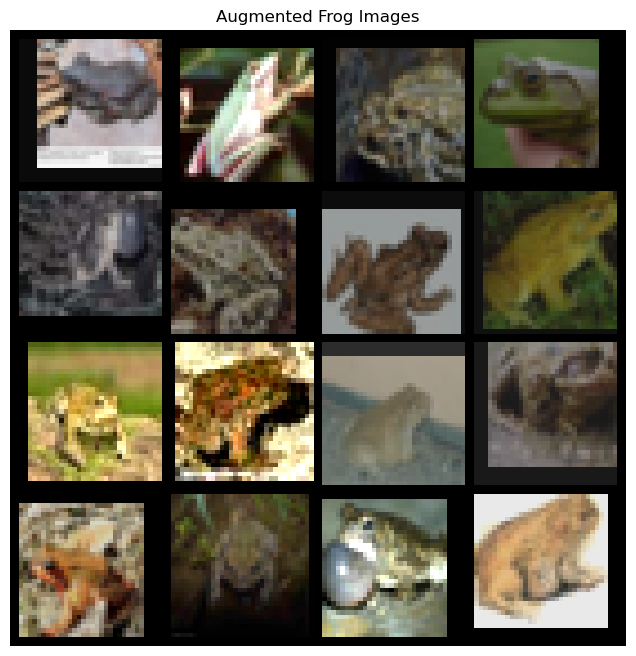

In [156]:
# Make a grid
img_grid = torchvision.utils.make_grid(images, nrow=4)

# Convert to numpy and show
plt.figure(figsize=(8, 8))
plt.imshow(img_grid.permute(1, 2, 0).numpy())
plt.axis('off')
plt.title('Augmented Frog Images')
plt.show()

In [157]:
# New traningdataset
complete_traningdata = training_data + augmented_frog_iamges

In [158]:
# Present the traning data
print("Traning data")
print_stats(complete_traningdata, classes)

Traning data
Total images: 55000
Label 0 (plane): 5000
Label 1 (car): 5000
Label 2 (bird): 5000
Label 3 (cat): 5000
Label 4 (deer): 5000
Label 5 (dog): 5000
Label 6 (frog): 10000
Label 7 (horse): 5000
Label 8 (ship): 5000
Label 9 (truck): 5000


In [159]:
# Convert to binary values 1 for frogs and o for other classes
binary_trainset = FrogBinaryDataset(complete_traningdata)

# Put into dataloader
trainloader = DataLoader(binary_trainset, batch_size=64, shuffle=True)

In [160]:
# Calculate lengths for the split
total_size = len(test_data)
split_size = int(total_size // 2)

# Splitting the testset into equal parts test and validation
test_subset = Subset(test_data, range(split_size))
val_subset = Subset(test_data, range(split_size, total_size))


In [161]:
# Present the test and validation data
print("Testdata")
print_stats(test_subset, classes)
print("\n")
print("Validationdata")
print_stats(val_subset, classes)

Testdata
Total images: 5000
Label 0 (plane): 488
Label 1 (car): 505
Label 2 (bird): 512
Label 3 (cat): 497
Label 4 (deer): 507
Label 5 (dog): 488
Label 6 (frog): 491
Label 7 (horse): 495
Label 8 (ship): 504
Label 9 (truck): 513


Validationdata
Total images: 5000
Label 0 (plane): 512
Label 1 (car): 495
Label 2 (bird): 488
Label 3 (cat): 503
Label 4 (deer): 493
Label 5 (dog): 512
Label 6 (frog): 509
Label 7 (horse): 505
Label 8 (ship): 496
Label 9 (truck): 487


## Building the Test and Validation Dataset

To evaluate model performance, we split a 10,000-sample dataset evenly into test and validation sets, each containing 5,000 images. The split was done using index-based slicing without stratification, which may cause minor class imbalances.

The original dataset is fairly balanced across 10 classes, with around 490–512 images per class. However, in the binary setup, frogs make up about 10% of each subset.

This introduces a class imbalance that negatively affects performance. While the original balance is suitable for multi-class classification, it becomes problematic when the model must distinguish one class from nine others. This issue could have been addressed through resampling or by applying class weights during training.

Another approach would be to split the test and validation data into a 50/50 ratio of frog and non-frog classes. We decided not to use this method because we wanted our model to remain representative of the original CIFAR-10 dataset.

In [162]:
# Convert to binary values 1 for frogs and 0 for other classes
binary_testset = FrogBinaryDataset(test_subset)
binary_validationset = FrogBinaryDataset(val_subset)

In [163]:
# Wrap in DataLoaders
testloader = DataLoader(binary_testset, batch_size=64, shuffle=True)
valoader = DataLoader(binary_validationset, batch_size=64, shuffle=True)

## Convolutional Neural Network 

We created our own convolutional neural network (CNN) called “FrogClassifier” to perform binary classification. The architecture begins with two convolutional layers, each utilizing a 5×5 kernel to extract spatial features from the input images. These layers are followed by batch normalization, ReLU activation, and max pooling to improve training efficiency and preserve key visual features such as edges and textures.

The output from the convolutional blocks is flattened and passed through three fully connected layers, incorporating dropout and batch normalization to reduce overfitting and improve stability. The final output layer returns two logits, corresponding to the binary classification task (frog or not-frog).

We use batch normalization to stabilize training and enable faster convergence (Piyush Kashyap, 2024), and max pooling to preserve important spatial features—supported by findings from Zhao and Zhang (2024), who demonstrated that it outperforms average pooling on CIFAR datasets. Furthermore, we use dropout to randomly deactivate neurons, reducing overfitting, and ReLU activation to introduce nonlinearity by converting negative values to zero (Krishnamurthy, 2024).

Lastly, we implement a forward function to define the sequence in which data flows through the model, applying each transformation step—such as ReLU, dropout, and pooling—in the correct order to produce the final output.

In [164]:
# Class defining the convolutional neural network
class FrogClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        # First convolutional layer: input has 3 channels (RGB), output has 12 filters
        # Each filter has a kernel size of 5x5
        self.conv_layer1 = nn.Conv2d(3, 12, kernel_size=5)

        # Batch normalization to stabilize and accelerate training after the first conv layer
        self.bn1 = nn.BatchNorm2d(12)
        
        # Max pooling layer to reduce spatial dimensions (downsampling)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Second convolutional layer: input has 12 channels, output has 24 filters
        self.conv_layer2 = nn.Conv2d(12, 24, kernel_size=5)
        
        # Batch normalization after the second conv layer
        self.bn2 = nn.BatchNorm2d(24)
        
        # First fully connected (dense) layer: input is flattened from conv output (24 * 5 * 5)
        # Output is 120 features
        self.fully_connected1 = nn.Linear(24 * 5 * 5, 120)
        self.bn3 = nn.BatchNorm1d(120)
        self.dropout1_fc = nn.Dropout(p=0.3)  # Dropout to reduce overfitting
        
        # Second fully connected layer: 120 inputs to 84 outputs
        self.fully_connected2 = nn.Linear(120, 84)
        self.bn4 = nn.BatchNorm1d(84)
        self.dropout2_fc = nn.Dropout(p=0.3)
        
        # Final fully connected layer: output 2 values (binary classification: frog or not)
        self.fully_connected3 = nn.Linear(84, 2)

    def forward(self, data):
        # Apply first convolution -> batch norm -> ReLU -> pooling
        data = self.pool(F.relu(self.bn1(self.conv_layer1(data))))
        
        # Apply second convolution -> batch norm -> ReLU -> pooling
        data = self.pool(F.relu(self.bn2(self.conv_layer2(data))))
        
        # Flatten the output for the fully connected layers
        data = torch.flatten(data, 1)
        
        # First dense layer with ReLU, batch norm, and dropout
        data = F.relu(self.bn3(self.fully_connected1(data)))
        data = self.dropout1_fc(data)
        
        # Second dense layer with ReLU, batch norm, and dropout
        data = F.relu(self.bn4(self.fully_connected2(data)))
        data = self.dropout2_fc(data)
        
        # Final output layer (logits for 2 classes)
        data = self.fully_connected3(data)
        
        return data

# (Ingole, 2024)

In [165]:
# defining an optimizer and lossfucntion
neural_network = FrogClassifier()

# Using cross entropy loss
loss_function = nn.CrossEntropyLoss()
optimizer = AdamW(neural_network.parameters(), lr=0.001, weight_decay=0.01)

# (PyTorch Contributors, 2024)

## Adam and optimizer 

To start training the “FrogClassifier” model, we use CrossEntropyLoss as the loss function and AdamW as the optimizer. AdamW decouples weight decay from the gradient update, leading to better generalization and training stability (Contributors, 2025).

AdamW improves regularization behavior without affecting the optimizer’s internal moments. This is beneficial in convolutional networks, where overfitting is often a concern.

In [166]:
# Defining the earlystopping class
early_stop_callback = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.00, patience=3, 
    verbose=False, mode="max")

# Defining a the checkpoint class
checkpoint = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="best-model"
)

# Apply the early stop on the traning
trainer = Trainer(callbacks=[early_stop_callback])

# (Lightning.ai, 2024)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Training the Model 

The “EarlyStopping” callback monitors accuracy (val_accuracy) and stops training if it doesn’t improve after 3 consecutive epochs. We chose 3 because it's long enough to detect improvements, but also short enough to prevent wasting resources. By setting “mode=max”, the callback looks for the highest possible accuracy, which prevents unnecessary training once the model has plateaued, saving time and reducing the risk of overfitting.

We also use “ModelCheckpoint” to automatically save the best-performing model during training. It monitors the validation loss and keeps the model with the lowest loss. This ensures the most generalizable version of the model, even if later epochs result in overfitting.

In [167]:
# List for tracking the traning loss
list_of_train_loss = []
# List for tracking validation loss
list_of_val_loss = []
# Number of epochs to run
epochs = range(20)

# Nummber of epochs with worse loss before stopping
patience = 3
# Best val loss recorded
best_val_loss = float('inf')
# Epochs number
counter = 0

# Traning loop
for epoch in epochs:
    print(f"\nEpoch {epoch+1} / {max(epochs)}")
    
    # Training
    neural_network.train()
    # Current loss
    running_loss = 0.0
    
    # Iterating over the traning data
    for inputs, labels in trainloader:
        # Set optimizer
        optimizer.zero_grad()
        # Outputs returned from the model
        outputs = neural_network(inputs)
        # Compute loss 
        loss = loss_function(outputs, labels)
        loss.backward()
        # Perform a single optimization step
        optimizer.step()
        running_loss += loss.item()
    
    # Compute the avrage loss form traning
    avg_train_loss = running_loss / len(trainloader)
    # Add it to the list of traning loss
    list_of_train_loss.append(avg_train_loss)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # Validation
    neural_network.eval()
    # Validation loss
    val_loss = 0.0
    # Correctly predicted
    correct = 0
    # Total predictions
    total = 0
    
    # Context-manager that disables gradient calculation 
    with torch.no_grad():
        # Iterate over batches in the validation dataset
        for val_inputs, val_labels in testloader:
            # Forward pass: compute model outputs for validation inputs
            outputs = neural_network(val_inputs)
            # Compute loss between outputs and true labels
            loss = loss_function(outputs, val_labels)
            # Accumulate validation loss
            val_loss += loss.item()
            
            # Get the predicted class labels
            _, predicted = torch.max(outputs, 1)
            # Update total number of samples seen
            total += val_labels.size(0)
            # Update number of correctly predicted samples
            correct += (predicted == val_labels).sum().item()

    # Calculate average validation loss over all batches
    avg_val_loss = val_loss / len(testloader)
    # Append current validation loss to the history list
    list_of_val_loss.append(avg_val_loss)
    # Calculate validation accuracy
    val_acc = 100 * correct / total

    # Print validation metrics
    print(f"Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.2f}%")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        # If current validation loss improves, update best loss and reset counter
        best_val_loss = avg_val_loss
        counter = 0
        # Save the current best model weights
        torch.save(neural_network.state_dict(), "best_model.pth")
    else:
        # If no improvement, increment the counter
        counter += 1
        print(f"No improvement in validation loss ({counter}/{patience})")
        # If no improvement for 'patience' consecutive checks, stop training
        if counter >= patience:
            print("Early stopping triggered.")
            break
        
# (Olu-Ipinlaye, 2024)
# (Koehrsen, 2018)


Epoch 1 / 19
Train Loss: 0.2284
Validation Loss: 0.1640 | Accuracy: 93.40%

Epoch 2 / 19
Train Loss: 0.1687
Validation Loss: 0.1723 | Accuracy: 92.66%
No improvement in validation loss (1/3)

Epoch 3 / 19
Train Loss: 0.1523
Validation Loss: 0.1485 | Accuracy: 94.26%

Epoch 4 / 19
Train Loss: 0.1397
Validation Loss: 0.1368 | Accuracy: 94.96%

Epoch 5 / 19
Train Loss: 0.1309
Validation Loss: 0.1233 | Accuracy: 95.40%

Epoch 6 / 19
Train Loss: 0.1207
Validation Loss: 0.1289 | Accuracy: 95.36%
No improvement in validation loss (1/3)

Epoch 7 / 19
Train Loss: 0.1129
Validation Loss: 0.1186 | Accuracy: 95.72%

Epoch 8 / 19
Train Loss: 0.1060
Validation Loss: 0.1233 | Accuracy: 95.26%
No improvement in validation loss (1/3)

Epoch 9 / 19
Train Loss: 0.1001
Validation Loss: 0.1242 | Accuracy: 95.80%
No improvement in validation loss (2/3)

Epoch 10 / 19
Train Loss: 0.0942
Validation Loss: 0.1277 | Accuracy: 95.48%
No improvement in validation loss (3/3)
Early stopping triggered.


We trained the model for up to 20 epochs, manually tracking both training and validation loss. At each epoch, the model was trained on the training set and evaluated on the validation set, with accuracy and loss logged. We set the maximum number of epochs to 25 because the model typically converged and triggered early stopping between epochs 10 and 15. Setting it to 25 ensured sufficient training time without risking unnecessary overfitting.

Training was halted, and the best model was saved using torch.save(). This ensured that we preserved the model with the lowest validation loss without overtraining.

We found that our model is learning well, given the steady decrease in training loss. However, our validation loss is relatively unstable but generally shows a downward trend. The varying validation results show some signs of overfitting, which can be attributed to the relatively small test set, making it difficult for the model to generalize. To summarize, the performance shows that the model is learning what a frog is but displays some signs of overfitting.

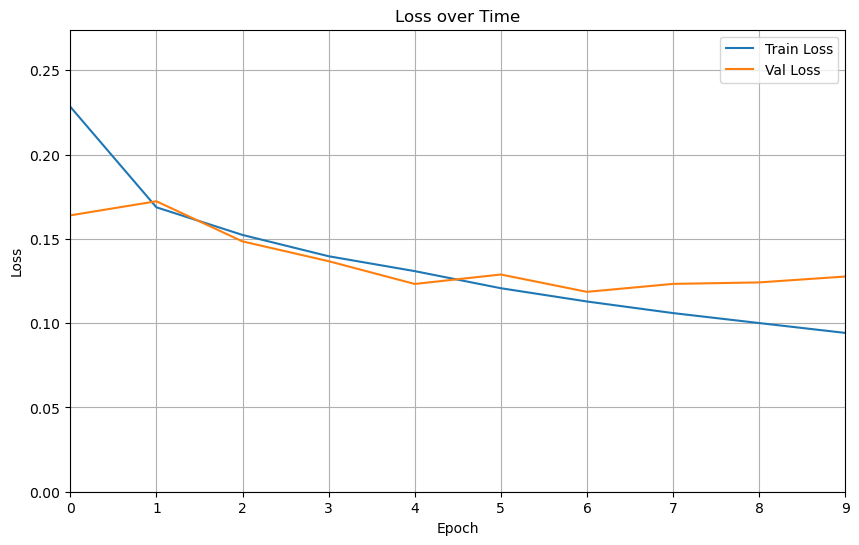

In [168]:
# Plotting
epochs = range(len(list_of_train_loss))
fig, graph = plt.subplots(figsize=(10, 6))

# Plot average losses per epoch
graph.plot(list(epochs), list_of_train_loss, label='Train Loss', color='tab:blue')
graph.plot(list(epochs), list_of_val_loss, label='Val Loss', color='tab:orange')

# Axis limits and labels
graph.set_ylim(0, max(list_of_val_loss + list_of_train_loss) * 1.2)
# X axsis range between min and max epochs
graph.set_xlim(min(epochs), max(epochs))
graph.set_xticks(epochs) 
graph.legend()
plt.title("Loss over Time")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# (Hunter, 2025)

## Validation 


In [169]:
# Save the model
neural_network.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

## Evaluation

When evaluating the model, we use the validation dataset to assess the accuracy and reliability of the model’s predictions. This step is crucial because it provides an unbiased evaluation of how well the model is learning and generalizing to unseen data. By comparing the model’s predictions to the actual labels in the validation set, we gain insight into its performance, including potential issues like overfitting or underfitting. Ultimately, this helps us determine how well the model is performing.

In [170]:
# set model to eval mode
neural_network.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.3, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.3, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [171]:
# Evaluation loop

# Initialize metrics
# Correct predictions
correct = 0
# Total predictions
total = 0
# Running valuation loss
val_loss = 0.0

true_positive = 0
false_negative = 0

# List of all predictions
all_preds = []
# List of all labels
all_labels = []

# Run evaluation
with torch.no_grad():
    # Iterate over the validation loss 
    for val_inputs, val_labels in valoader:
        outputs = neural_network(val_inputs)
        loss = loss_function(outputs, val_labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += val_labels.size(0)
        correct += (predicted == val_labels).sum().item()

        # For recall calculation (assuming frog = 1)
        true_positive += ((predicted == 1) & (val_labels == 1)).sum().item()
        false_negative += ((predicted == 0) & (val_labels == 1)).sum().item()

        # Store predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())

# 

By using a confusion matrix, we get a visual representation of how well the model performs and which labels it struggles with. As a result, we see that our model is largely successful at correctly labeling both the non-frog and frog classes.

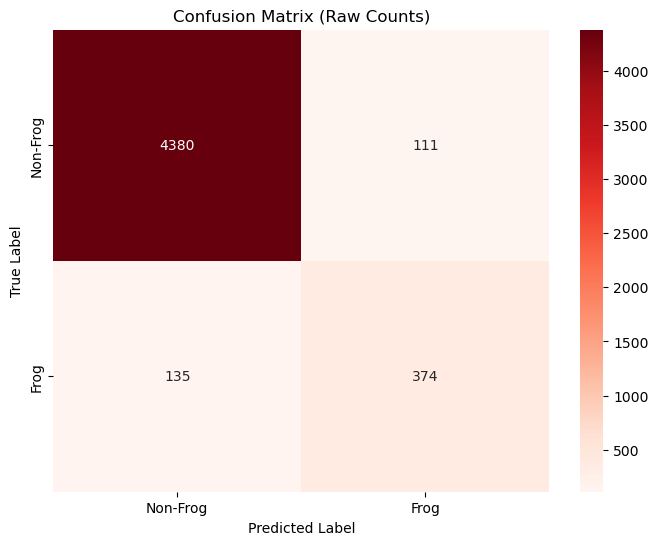


Classification Report:
              precision    recall  f1-score   support

    Non-frog       0.97      0.98      0.97      4491
        Frog       0.77      0.73      0.75       509

    accuracy                           0.95      5000
   macro avg       0.87      0.86      0.86      5000
weighted avg       0.95      0.95      0.95      5000



In [172]:
# Confusion Matrix with raw counts
labels = ["Non-Frog", "Frog"]
confusion_matrix = confusion_matrix(all_labels, all_preds)

# Create DataFrame with raw counts
df_confusion_matrix = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

# Plot heatmap with counts
plt.figure(figsize=(8, 6))
sn.heatmap(df_confusion_matrix, annot=True, fmt="d", cmap="Reds")
plt.title("Confusion Matrix (Raw Counts)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


# Classification Report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["Non-frog", "Frog"]))

# (scikit-learn developers, 2025)

## Prediction on New image

When presenting the model with new images, we need to augment them to make them similar to the CIFAR-10 dataset. Since the images we are taking in don’t suit our model, we are transforming them. The transformation ensures a consistent input shape for the model and improves convergence speed and stability during training, similar to what we did in Task IIa.

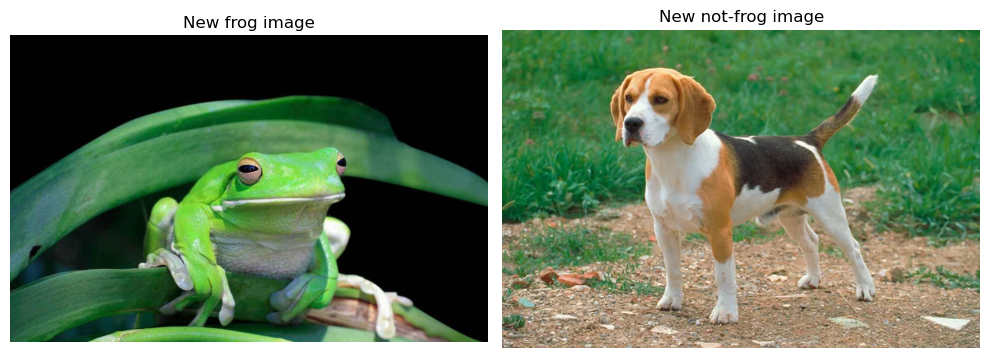

In [173]:
# Present new image

# New frog image
frog_image = Image.open("new_frog_picture.jpg")
# New non-forg image 
not_frog_image = Image.open("new_dog_picture.jpg")


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Show the frog image
axes[0].imshow(frog_image)
axes[0].set_title("New frog image")
axes[0].axis("off")

# Show the non-forg image
axes[1].imshow(not_frog_image)
axes[1].set_title("New not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Here we presenting the images of a frog and a non-frog so we can compare. 

In [174]:
# Transforms
# Transform for changing the image into a 32x32 and normalizing
new_transform = v2.Compose([
    # Resize to 32x32
    v2.Resize((32, 32)),
    # Convert to tensor            
    v2.ToTensor(),
    # Rescale                 
    v2.Normalize((0.5, 0.5, 0.5),     
                         (0.5, 0.5, 0.5))
])

# Unnormalize for display
unnormalize = v2.Normalize(
    mean=[-1.0, -1.0, -1.0],
    std=[2.0, 2.0, 2.0]
)

# (Torch Contributors, 2017)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [175]:
# Present image to be processed

# Apply transform
transformed_frog_image = new_transform(frog_image)
transformed_not_frog_image = new_transform(not_frog_image)


transformed_frog_image = unnormalize(transformed_frog_image)
transformed_not_frog_image = unnormalize(transformed_not_frog_image)

# Convert to (H, W, C) and clip for valid pixel range
display_image_forg = transformed_frog_image.permute(1, 2, 0).numpy()
display_image_not_forg = transformed_not_frog_image.permute(1, 2, 0).numpy()

# Clip intervals outside of normalisation range
display_image_forg = np.clip(display_image_forg, 0, 1)
display_image_not_forg = np.clip(display_image_not_forg, 0, 1)

## Present image to be processed 

When we reverse the normalization, we bring the pixel values back to the [0, 1] range. This is important for displaying the images with tools that expect pixel values in that range.

This handles both the technical requirements of PyTorch and the formatting needs for visual inspection, which is helpful when visualizing training data.

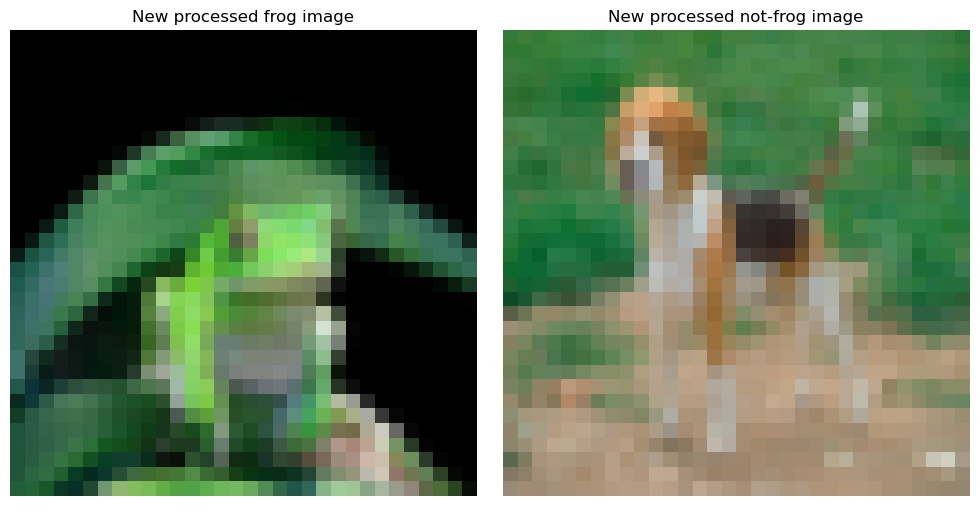

In [176]:
# Display preprocessed images

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(display_image_forg)
axes[0].set_title("New processed frog image")
axes[0].axis("off")


axes[1].imshow(display_image_not_forg)
axes[1].set_title("New processed not-frog image")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [177]:
# Load in model
model = FrogClassifier()
# Load in the model
model.load_state_dict(torch.load("./best_model.pth"))
model.eval()

FrogClassifier(
  (conv_layer1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_layer2): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully_connected1): Linear(in_features=600, out_features=120, bias=True)
  (bn3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1_fc): Dropout(p=0.3, inplace=False)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (bn4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2_fc): Dropout(p=0.3, inplace=False)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)

In [178]:
images = [frog_image, not_frog_image]
# Predicted labels
labels = []

# Make prediction
for img in images:
    # Preprocess image
    processed_img = new_transform(img).unsqueeze(0)
    
    with torch.no_grad():
        
        output = model(processed_img)

        # Prediction
        prediction = torch.argmax(output, dim=1).item()

        # Confidence
        probability = torch.softmax(output, dim=1)
        confidence = probability[0][prediction].item()

        label = f"{'Frog' if prediction == 1 else 'Non-Frog'} ({confidence:.2%})"
        labels.append(label)

# (Pytorch, 2024)

## Make prediction 

This loop handles the inference step, where each image is passed through the model to get a class prediction and its associated confidence. The loop ensures that the image is transformed consistently with the training data, adds a batch dimension, disables gradient tracking for efficiency during inference, converts the raw model output into probabilities, and fetches the probability score of the predicted class. This creates a readable label, combining the predicted class name and its confidence as a percentage.

It confirms whether the model is generalizing well to individual examples while also exposing how certain it is about its decision.

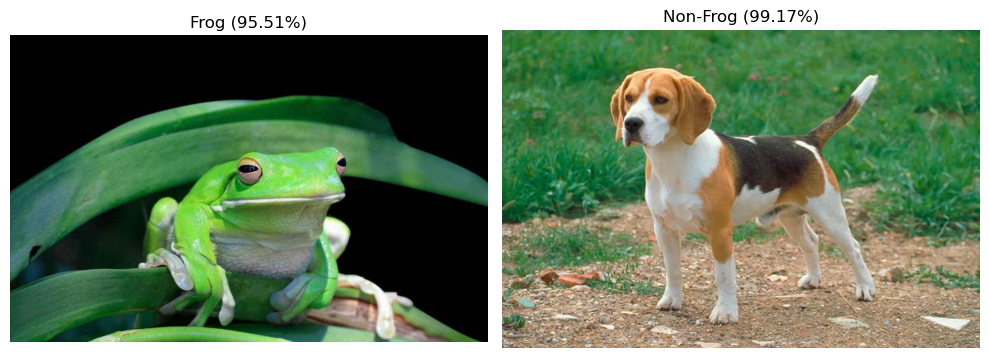

In [179]:
# Create plot
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display images
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(labels[i], fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

Our model achieves very strong results, with 95.51% confidence on the new frog image and 99.17% confidence on the new non-frog image. This shows that our model performed very well when presented with photos not included in its training data. However, this is only one image, and further testing with different frog images would provide a better understanding of our model's effectiveness as a frog classifier.

## Sources
PyTorch. (2017). *Training a Classifier*. pytorch.org. 
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Nekouei, F. (2023). *CIFAR-10 Image Classification* with CNN. 
    https://www.kaggle.com/.

PyTorch. (2024). *Datasets & DataLoaders*. pytorch.org.
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

PyTorch. (2024, desember 20). *Training a Classifier* . Retrieved from pytorch.org: 
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

Nekouei, F. (2023). *CIFAR-10 Image Classification with CNN*. Retrieved from kaggle.com: 
    https://www.kaggle.com/code/farzadnekouei/cifar-10-image-classification-with-cnn

PyTorch. (2025, January 16). *Datasets & DataLoaders*. Retrieved from pytorch.org: 
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Ruman. (2023, November 6). *Ultimate Guide to Fine-Tuning in PyTorch* : Part 3 —Deep Dive to PyTorch Data Transforms with Examples. Retrieved from Medium.com: 
    https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde

Ingole, M. (2024, Juni 16). *Simple Convolutional Neural Network (CNN) for Dummies in PyTorch: A Step-by-Step Guide*. Retrieved from Medium.com:      https://medium.com/@myringoleMLGOD/simple-convolutional-neural-network-cnn-for-dummies-in-pytorch-a-step-by-step-guide-6f4109f6df80

Contributors, P. (2025). AdamW. *Retrieved from pytorch.org*: 
    https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html

Contributors, P. (2024). *CrossEntropyLoss*. Retrieved from https://pytorch.org/: 
    https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

lightning.ai. (u.d.). *Early Stopping*. Retrieved from lightning.ai: 
    https://lightning.ai/docs/pytorch/stable/common/early_stopping.html

w3schools.com. (u.d.). Retrieved from 
    https://www.w3schools.com/python/matplotlib_plotting.asp

Koehrsen, W. (2018). *cifar10_cnn_exercise.ipynb*. Retrieved from 
    https://github.com/WillKoehrsen/deep-learning-v2-pytorch/blob/master/convolutional-neural-networks/cifar-cnn/cifar10_cnn_exercise.ipynb

developers, s.-l. (2025). *confusion_matrix*. Retrieved from scikit-learn.org: 
    https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Olu-Ipinlaye, O. (2024 , October 10). *Training, Validation and Accuracy in PyTorch*. Retrieved from 
    https://www.digitalocean.com/: https://www.digitalocean.com/community/tutorials/training-validation-and-accuracy-in-pytorch

Hunter, J., Dale, D., Firing, E., & Droettboom, M. (2012). *Image tutorial*. Retrieved from matplotlib.org: 
    https://matplotlib.org/stable/tutorials/images.html

Hallaj, P. (2023, September 20). Data Augmentation: Benefits and Disadvantages. Hentet fra Medium.com: 
    https://medium.com/@pouyahallaj/data-augmentation-benefits-and-disadvantages-38d8201aead